In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import shap
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GroupKFold
from hyperopt import fmin, atpe, Trials, tpe, hp, Trials, STATUS_OK
import colorama
import random
import warnings
import matplotlib.pyplot as plt


# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


### Import the dataset after the FE

In [2]:
core_data = pd.read_parquet("../data/processed/core_data_fe.parquet", engine="pyarrow")

In [4]:
core_data.describe()

,rating_account_id,age,contract_lifetime_days,remaining_binding_days,has_special_offer,is_magenta1_customer,available_gb,gross_mrc,has_done_upselling,produkte&services-tarifdetails_n,produkte&services-tarifwechsel_n,prolongation_n,rechnungsanfragen_n,produkte&services-tarifdetails_recency,produkte&services-tarifwechsel_recency,prolongation_recency,rechnungsanfragen_recency,avg_gb_used,std_gb_used,max_gb_used,min_gb_used,used_gb_range,used_roaming_ratio,usage_months,num_contracts,binding_ratio,price_per_gb,has_multiple_contracts
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,85621.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.00000,100000.000000,100000.000000,100000.000000
mean,550028.58357,43.860250,777.766330,0.888140,0.303300,0.303360,24.983590,37.494571,0.06974,0.364180,0.358590,0.365720,0.365480,827.443420,829.484520,828.025060,826.486890,13.989799,4.785056,19.243406,8.741256,10.502150,0.300060,4.0,2.18992,0.207878,1.582041,0.693590
std,260289.65646,13.728254,490.657801,345.398756,0.459686,0.459712,17.088507,19.126175,0.25471,0.984278,0.961006,0.982333,0.969192,356.530817,354.857137,355.771958,357.141957,17.292059,6.525954,23.811755,11.238049,14.268576,0.229945,0.0,1.09809,0.281220,1.283012,0.461004
min,100008.00000,18.000000,7.000000,-730.000000,0.000000,0.000000,0.000000,5.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.100000,0.000000,0.000000,0.000000,4.0,1.00000,0.000000,0.100000,0.000000
25%,324903.25000,36.000000,369.000000,-233.000000,0.000000,0.000000,10.000000,20.920000,0.00000,0.000000,0.000000,0.000000,0.000000,999.000000,999.000000,999.000000,999.000000,1.081250,0.427200,1.150000,0.975000,0.900000,0.250000,4.0,1.00000,0.000000,0.918333,0.000000
50%,551108.00000,43.000000,731.000000,0.000000,0.000000,0.000000,20.000000,38.160000,0.00000,0.000000,0.000000,0.000000,0.000000,999.000000,999.000000,999.000000,999.000000,5.062500,1.543535,5.300000,4.800000,3.400000,0.250000,4.0,2.00000,0.000000,1.252500,1.000000
75%,775866.25000,49.000000,1095.250000,236.000000,1.000000,1.000000,40.000000,54.080000,0.00000,0.000000,0.000000,0.000000,0.000000,999.000000,999.000000,999.000000,999.000000,15.362500,4.427659,16.225000,14.550000,9.400000,0.500000,4.0,3.00000,0.381757,1.670000,1.000000
max,999999.00000,100.000000,1825.000000,730.000000,1.000000,1.000000,50.000000,70.000000,1.00000,10.000000,10.000000,10.000000,10.000000,999.000000,999.000000,999.000000,999.000000,67.850000,29.943280,70.000000,65.200000,55.000000,1.000000,4.0,8.00000,0.998609,7.000000,1.000000


Check again the missing values

In [3]:
missing = core_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(core_data)) * 100

# Combine into a clean summary table
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent.round(2)
})

missing_df

,Missing Count,Missing %
available_gb,14379,14.38


In [3]:
def convert_to_categorical(df, columns):
    """
    Converts specified columns in a DataFrame to categorical dtype.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame
        columns (list): List of column names to convert
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
        else:
            print(f"⚠️ Column '{col}' not found in DataFrame.")

Categorical and binary variables were converted to categorical data types to ensure appropriate handling during modeling.

So, apart from smartphone_brand, we also gonna treat as categorical the available_gb which has discrete values in fixed increments (0–50 GB).

In addition to those, we also treat as categorical the binary ones: has_special_offer, is_magenta1_customer, has_multiple_contracts.

In [24]:
convert_to_categorical(core_data, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])

# Model Building

### Build Training / OOS partitions

We build a numeric customer_id variable cause we want to sort later or treat as numerical anyway.

In [7]:
core_data['customer_id_numeric'] = core_data['customer_id'].astype(float)

In [21]:
ordered_customers = core_data[['customer_id', 'customer_id_numeric']].drop_duplicates().sort_values('customer_id_numeric')


### Data Splitting Strategy

We split the dataset into two main parts: **Training block** and **Out-of-Sample (OOS)**.

####  Training block
The training block is further split into:
- **Training set**: used for final model fitting after selecting the best hyperparameters.
- **Validation set**: used for tuning hyperparameters during model selection.
- **Test set**: used for evaluating model performance and checking for issues like overfitting.

All three are split by `customer_id` to ensure no customer appears in multiple sets.

####  Out-of-Sample (OOS)
The OOS partition is kept completely separate in terms of `customer_id`, with no overlap with training, validation, or test sets.

Because we don’t have time-based labels directly tied to customers, we use a practical assumption:  
Customer IDs are assigned sequentially — so **higher customer_id values likely represent more recently created customers**.

Based on that, we hold out the **most recent 15% of customer_ids** as a distinct evaluation group.  
While this is not a time-based split, it simulates how the model might perform on a **fresh customer cohort**.  
This partition can be used as a **production-level performance proxy**, offering a realistic view of generalization.

In [23]:
cutoff = int(0.85 * len(ordered_customers))
train_customers = ordered_customers.iloc[:cutoff]['customer_id']
oos_customers = ordered_customers.iloc[cutoff:]['customer_id']

core_data['is_oos'] = core_data['customer_id'].isin(oos_customers).astype(int)

In [25]:
print("OOS customer ratio:", core_data['is_oos'].mean().round(30))

OOS customer ratio: 0.15024


In [26]:
train_raw = core_data[core_data['is_oos'] == 0].copy()
oos_raw = core_data[core_data['is_oos'] == 1].copy()

Overlap between training and OOS ids

In [27]:
# Unique customers in each set
train_customers = set(train_raw['customer_id'])
oos_customers = set(oos_raw['customer_id'])

# Intersecting customers
overlap = train_customers.intersection(oos_customers)

print(f"🔍 Overlapping customers: {len(overlap)}")

🔍 Overlapping customers: 0


Splitting Train partition into Train / Test / Validation at a ratio of 70:15:15

Again, checks for overlapping customers.

In [28]:
unique_customers = train_raw['customer_id'].unique()

train_customers, temp_customers = train_test_split(
    unique_customers, test_size=0.3, random_state=10)

val_customers, test_customers = train_test_split(
    temp_customers, test_size=0.5, random_state=10)

X_train = train_raw[train_raw['customer_id'].isin(train_customers)].reset_index(drop=True)
X_val = train_raw[train_raw['customer_id'].isin(val_customers)].reset_index(drop=True)
X_test = train_raw[train_raw['customer_id'].isin(test_customers)].reset_index(drop=True)

train_customers = set(X_train['customer_id'].unique())
val_customers = set(X_val['customer_id'].unique())
test_customers = set(X_test['customer_id'].unique())

overlap_train_val = train_customers.intersection(val_customers)
overlap_train_test = train_customers.intersection(test_customers)
overlap_val_test = val_customers.intersection(test_customers)

print(f"Train & Val overlap: {len(overlap_train_val)} customers")
print(f"Train & Test overlap: {len(overlap_train_test)} customers")
print(f"Val & Test overlap: {len(overlap_val_test)} customers")


Train & Val overlap: 0 customers
Train & Test overlap: 0 customers
Val & Test overlap: 0 customers


#### Export all 4 datasets for re-producibility

In [ ]:
### X_train.to_parquet('../data/processed/X_train.parquet', index=False)
### X_val.to_parquet('../data/processed/X_val.parquet', index=False)
### X_test.to_parquet('../data/processed/X_test.parquet', index=False)
### oos_raw.to_parquet('../data/processed/X_oos.parquet', index=False)

In [29]:
X_train = pd.read_parquet("../data/processed/X_train.parquet", engine="pyarrow")
X_val = pd.read_parquet("../data/processed/X_val.parquet", engine="pyarrow")
X_test = pd.read_parquet("../data/processed/X_test.parquet", engine="pyarrow")
X_oos = pd.read_parquet("../data/processed/X_oos.parquet", engine="pyarrow")

Convert once more into categorical for the modelling. 

In [30]:
convert_to_categorical(X_train, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_val, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_test, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_oos, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])

### Model Training

The hyperparameter space is structured to control tree complexity, variance, and overfitting.

num_leaves, max_depth, and min_data_in_leaf define the structure and size of individual trees.

feature_fraction and bagging_fraction introduce subsampling to manage variance.

lambda_l1, lambda_l2, cat_l2, and cat_smooth provide regularization, particularly for categorical inputs.

min_sum_hessian_in_leaf is tuned to ensure training stability while preserving model flexibility.

In [19]:
space = {
    'num_leaves': hp.quniform('num_leaves', 31, 128, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 40, 120, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.7, 1.0),
    'lambda_l1': hp.uniform('lambda_l1', 0, 5),
    'lambda_l2': hp.uniform('lambda_l2', 0, 3),
    'cat_l2': hp.uniform('cat_l2', 0.0, 10),
    'cat_smooth': hp.uniform('cat_smooth', 0.0, 10),
    'max_depth': hp.quniform('max_depth', 4, 8, 1),
    'min_sum_hessian_in_leaf': hp.uniform('min_sum_hessian_in_leaf', 0.001, 0.1) 
}

In [20]:
def get_lgb_params(space):
    lgb_params = dict()
    lgb_params['objective'] = 'binary'
    lgb_params['is_unbalance'] = True
    lgb_params['metric'] = 'auc'
    lgb_params['num_leaves'] = int(space['num_leaves'])
    lgb_params['min_data_in_leaf'] = int(space.get('min_data_in_leaf', 20))
    lgb_params['cat_l2'] = space['cat_l2']
    lgb_params['cat_smooth'] = space['cat_smooth']
    lgb_params['lambda_l1'] = space.get('lambda_l1', 0.0)
    lgb_params['lambda_l2'] = space.get('lambda_l2', 0.0)
    lgb_params['feature_fraction'] = space['feature_fraction']
    lgb_params['bagging_fraction'] = space['bagging_fraction']
    lgb_params['bagging_freq'] = 1
    lgb_params['tree_learner'] = 'data'
    lgb_params['num_threads'] = 1
    lgb_params['learning_rate'] = 0.05
    lgb_params['feature_pre_filter'] = False
    lgb_params['verbose'] = -1
    lgb_params['max_depth'] = int(space['max_depth'])
    lgb_params['min_sum_hessian_in_leaf'] = space['min_sum_hessian_in_leaf']
    lgb_params['seed'] = 42
    lgb_params['feature_fraction_seed'] = 42
    lgb_params['bagging_seed'] = 42
    lgb_params['drop_seed'] = 42
    lgb_params['data_random_seed'] = 42
    lgb_params['deterministic'] = True

    return lgb_params

This custom function (metric_func) is used during CV to provide an AUC evaluation for model monitoring and early stopping.

We have employed the sigmoid function in order to treat null values.

In [21]:
def metric_func(preds, train_data):
    try:
        labels = train_data.get_label()
        probs = 1 / (1 + np.exp(-preds))  
        auc = roc_auc_score(labels, probs)

        if np.isnan(auc):
            auc = 0.5
        return [('auc', auc, True)]

    except Exception as e:
        print(f"Evaluation error: {e}")
        return [('auc', 0.5, True)]  

This objective function defines the hyperparameter optimization objective. 

It performs cross-validation, evaluates mean validation AUC across folds, and logs boosting rounds. 

The final iteration's average AUC is returned as negative loss for minimization.

In [22]:
def objective(space, cur_best_loss, lgbtrain, folds, log_writer):
    lgb_params = get_lgb_params(space)
    sorted_params = sorted(space.items(), key=lambda z: z[0])
    params_str = ' '.join(['{}={}'.format(k, v) for k, v in sorted_params])
    print('Params: {}'.format(params_str))

    cvmodel = lgb.cv(
    lgb_params,
    lgbtrain,
    num_boost_round=10000,
    folds=folds,
    metrics='none',
    feval=metric_func,
    ##callbacks=[lgb.log_evaluation(period=10)]
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(period=50)
        ]
    )

    print("First AUC values:", cvmodel['valid auc-mean'][:10])

    print("cvmodel keys:", list(cvmodel.keys())) 
  
    nb_trees = len(cvmodel['valid auc-mean'])
    test_loss = cvmodel['valid auc-mean'][-1]
    print('nb_trees={} test_loss={}'.format(nb_trees, test_loss))
    log_writer.write('loss={:<7.5f} Params:{} nb_trees={}\n'.format(test_loss, params_str, nb_trees))
    log_writer.flush()

    return {'loss': -test_loss, 'status': STATUS_OK}

### Hyperparameters Tuning

GroupKFold (3-fold) is used to ensure that no customer_id appears across different folds, which prevents data leakage across folds.

We have manually produced and stored the folds for to re-use them and maintain consistency across modelling experiments/ trials. We also run overlap checks.

We have set N_HYPEROPT_PROBES = 20 due to the small dataset size instead of an exhaustive search.

LightGBM is known for its excellent performance on traditional classification/regression problems and for the fact that it often outperforms other algorithms such Random Forests or traditional Gradient Boosting Algorithms.

In addition to that, one of the key strengths of LightGBM is its speed, which often outperforms XGBoost.

In our case, given the missing values that exist in our dataset and the lack of variable names, LightGBM is known for its automatic handling of missing values.

If we had more time, we could also experiment with other options such as Random Forest, XGBoost or even Logistic Regression.

In [31]:
categorical_features = ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts']

In [ ]:
X_val = X_val.sort_values(['customer_id_numeric']).reset_index(drop=True)
y_val = X_val['has_done_upselling']


# =========================================================================

##nfold = 3
##gkf = GroupKFold(n_splits=nfold)
##folds = list(gkf.split(X_val, y_val, groups=X_val['customer_id_numeric']))

##with open("folds_groupk_val.pkl", "wb") as f:
##    pickle.dump(folds, f)

with open("folds_groupk_val.pkl", "rb") as f:
    folds = pickle.load(f)

_, val0 = folds[0]
_, val1 = folds[1]
_, val2 = folds[2]

p0 = X_val.iloc[val0]['customer_id_numeric'].unique()
p1 = X_val.iloc[val1]['customer_id_numeric'].unique()
p2 = X_val.iloc[val2]['customer_id_numeric'].unique()

print("Overlap p0/p1:", any(x in p1 for x in p0))
print("Overlap p1/p2:", any(x in p2 for x in p1))
print("Overlap p0/p2:", any(x in p2 for x in p0))

# =========================================================================

lgbtrain = lgb.Dataset(
    X_val.drop([
        'customer_id', 'customer_id_numeric', 'rating_account_id', 'has_done_upselling', 'is_oos', 'usage_months'
    ], axis=1),
    label=y_val
)
# =========================================================================

N_HYPEROPT_PROBES = 20
HYPEROPT_ALGO = atpe.suggest
colorama.init()

log_writer = open(
    'lgb-hyperopt-log-test.txt', 'w'
)

kwargs = {
    'cur_best_loss': np.inf,
    'lgbtrain': lgbtrain,
    'folds': folds,
    'log_writer': log_writer
}

HYPEROPT_ALGO = tpe.suggest 

trials = Trials()

best = fmin(
    fn=(lambda a: objective(a, **kwargs)),
    space=space,
    algo=tpe.suggest,
    max_evals=N_HYPEROPT_PROBES,
    trials=trials, 
    verbose=1
)

Overlap p0/p1: False
Overlap p1/p2: False
Overlap p0/p2: False


Params: bagging_fraction=0.9313499339841225 cat_l2=2.0796732785253114 cat_smooth=4.697514681159831 feature_fraction=0.764479428924618 lambda_l1=0.8050912599074905 lambda_l2=2.6820518450393602 max_depth=7.0 min_data_in_leaf=44.0 min_sum_hessian_in_leaf=0.045586953594491546 num_leaves=116.0
Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.591543 + 0.0206889                
Early stopping, best iteration is:                    
[11]	valid's auc: 0.59599 + 0.0211621
First AUC values:                                     
[0.5777283884266998, 0.5828293273614579, 0.5898848372194501, 0.5936784580805955, 0.5958132184847313, 0.5938853853522963, 0.5929573729631891, 0.594201493197683, 0.5955702812419129, 0.5935873092940662]
cvmodel keys:                                         
['valid auc-mean', 'valid auc-stdv']                  
nb_trees=11 test_loss=0.595990140174801               
Params: bagging_fraction=0.7568362840935033 cat_l2=8.757662194240064 cat_smooth=1

In [47]:
lgb_param_best = get_lgb_params(best)

### Model Training using the best hyperparameters

In [48]:
X_train = X_train
y_train = X_train['has_done_upselling']


lgbtrain = lgb.Dataset(
    X_train.drop([
        'customer_id', 'customer_id_numeric', 'rating_account_id', 'has_done_upselling', 'is_oos', 'usage_months'
    ], axis=1),
    label=y_train
)

##nfold = 3
##gkf = GroupKFold(n_splits=nfold)
##folds = list(gkf.split(X_train, y_train, groups=X_train['customer_id_numeric']))

##with open("folds_groupk_train.pkl", "wb") as f:
##    pickle.dump(folds, f)

with open("folds_groupk_train.pkl", "rb") as f:
    folds = pickle.load(f)

print('cv started')
cvmodel = lgb.cv(
    lgb_param_best,
    lgbtrain,
    num_boost_round=10000,
    folds=folds,
    metrics='none',
    feval=metric_func,
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(period=0)
        ]
    )

best_num_boost_round = len(cvmodel['valid auc-mean'])     #### average AUC on the validation fold within each CV split
print('training started')
lgbmodel = lgb.train(
    lgb_param_best,
    lgbtrain,
    num_boost_round=best_num_boost_round
)
print('training ended')

cv started
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid's auc: 0.610096 + 0.00282653
training started
training ended


### Export the full baseline model

In [ ]:
with open('../models/full_baseline_model.pkl', 'wb') as f:
    pickle.dump(lgbmodel, f)

##with open('../models/full_baseline_model.pkl', 'rb') as f:
##    lgbmodel = pickle.load(f)    

#### Cross-Validation AUC over Boosting Rounds

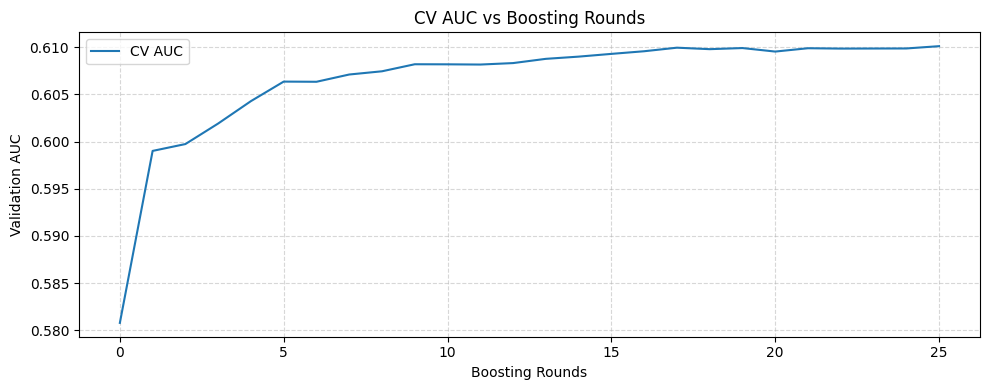

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(cvmodel['valid auc-mean'], label='CV AUC')
plt.xlabel("Boosting Rounds")
plt.ylabel("Validation AUC")
plt.title("CV AUC vs Boosting Rounds")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Validation AUC remains low and flat across all boosting rounds, indicating that the model is unable to extract predictive signal from the features. Especially after 60-61%.

### High-level Performance and Overfitting checks 

The model doesn't show a strong performance across the different non-overlapping partitions. 

The drop of performance between training and test partition is expected but doesn't necessarily indicate overfitting, mainly due to the small sample size. 

In [50]:
y_test = X_test['has_done_upselling']
y_val = X_val['has_done_upselling']

model = lgbmodel

features_used = model.feature_name()

X_train_lgb = X_train[features_used]
X_val_lgb = X_val[features_used]
X_test_lgb = X_test[features_used]

y_train_pred = model.predict(X_train_lgb)
y_val_pred = model.predict(X_val_lgb)
y_test_pred = model.predict(X_test_lgb)

auc_train = roc_auc_score(y_train, y_train_pred)
auc_val = roc_auc_score(y_val, y_val_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {auc_train:.4f}")
print(f"Validation AUC: {auc_val:.4f}")
print(f"Test AUC: {auc_test:.4f}")

Train AUC: 0.6493
Validation AUC: 0.6231
Test AUC: 0.6087


### Performance on OOS

We briefly investigate if the OOS partition shows some great discrepancy in performance vs the Test (mainly) and Training.

In [ ]:
X_oos = X_oos
y_oos = X_oos['has_done_upselling']

In [ ]:
features_used = model.feature_name()

X_oos = X_oos[features_used]

y_oos_pred = model.predict(X_oos)

auc_oos = roc_auc_score(y_oos, y_oos_pred)

print(f"OOS AUC: {auc_oos:.4f}")

OOS AUC: 0.6011


### Analysis of Performance on Test Set

### Model SHAP Values on Test Set

It is obviously a poor performing model, typical of unbalanced datasets with data without enough predictive power.

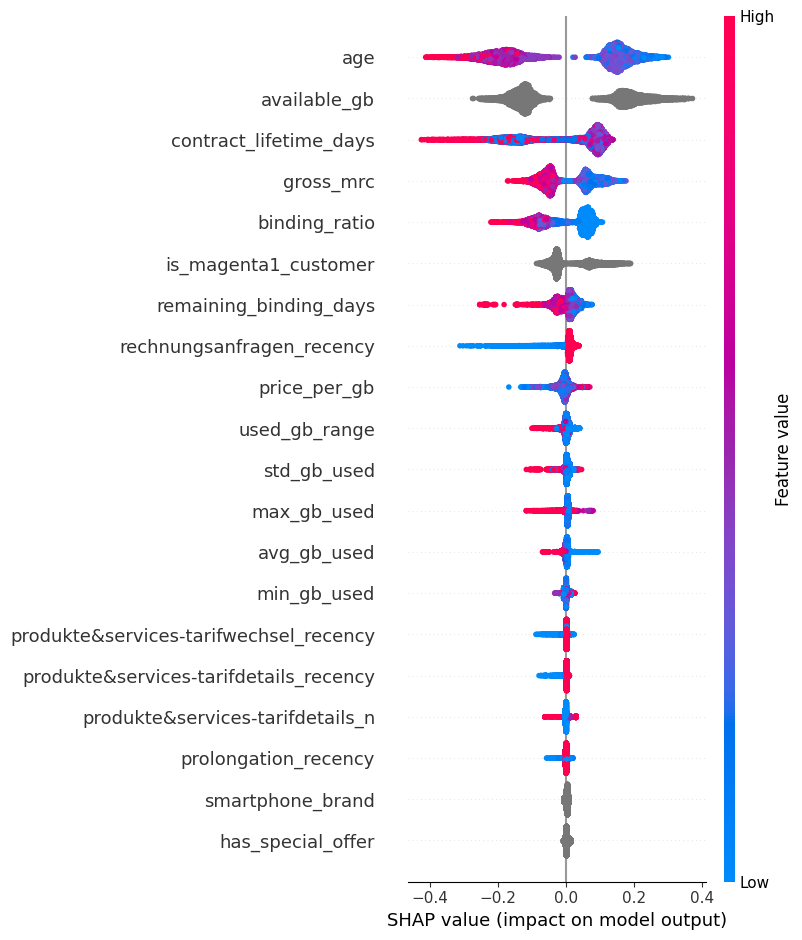

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_lgb)

    # If shap_values is a list (e.g., binary classifier), select class 1
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_test_lgb, show=True)
    else:
        shap.summary_plot(shap_values, X_test_lgb, show=True)


Looking at the SHAP values of the model, it appears that 'age' stands as the top predictive variable. More specifically, lower values of age, push the probability of upselling higher while lower ages lower the probabilities.

The next variable in importance is the available_gb which is a categorical variable. Certain categories of available_gb push the scores higher and other categories push the scores lower. The almost symmetrical shape of the distribution in addition to the ranking of the variable as second, shows that there is a clear differentiation between certain categories.

contract_lifetime_days shows a mixed contribution pattern. While higher values often push the score up, this isn't consistent across all observations.

Gross_mrc and binding_ratio show a clear picture: lower values in both features push the upsell probability higher whereas high values push the scores lower.

In [56]:
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values

shap_importance = pd.DataFrame({
    'feature': X_test_lgb.columns,
    'mean_abs_shap': np.abs(shap_vals).mean(axis=0)
})

shap_importance = shap_importance.sort_values(by='mean_abs_shap', ascending=True)

shap_importance.sort_values('mean_abs_shap', ascending = False)

,feature,mean_abs_shap
0,age,0.174
5,available_gb,0.159
1,contract_lifetime_days,0.113
6,gross_mrc,0.068
23,binding_ratio,0.067
4,is_magenta1_customer,0.048
2,remaining_binding_days,0.023
15,rechnungsanfragen_recency,0.019
24,price_per_gb,0.014
20,used_gb_range,0.008


### Precision and Recall by Probability Decile

In [54]:
display_thresholds = np.round(np.linspace(0.0, 1.0, 11), 2)
display_scores = []

for t in display_thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    display_scores.append((t, f1, precision, recall))

score_df_display = pd.DataFrame(display_scores, columns=['threshold', 'f1', 'precision', 'recall'])

fine_thresholds = np.round(np.linspace(0.01, 1.00, 100), 2)
fine_scores = []

for t in fine_thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test, y_pred_binary)
    fine_scores.append((t, f1))

fine_score_df = pd.DataFrame(fine_scores, columns=['threshold', 'f1'])
best_row = fine_score_df.loc[fine_score_df['f1'].idxmax()]

pd.set_option('display.float_format', '{:.3f}'.format)
print(" Precision, Recall, F1 at thresholds (10% steps):")
print(score_df_display.sort_values(by='threshold', ascending=False).to_string(index=False))

print(f"\n Max F1 score: {best_row.f1:.3f} at threshold = {best_row.threshold:.2f}")

 Precision, Recall, F1 at thresholds (10% steps):
 threshold    f1  precision  recall
     1.000 0.000      0.000   0.000
     0.900 0.000      0.000   0.000
     0.800 0.000      0.000   0.000
     0.700 0.000      0.000   0.000
     0.600 0.000      0.000   0.000
     0.500 0.024      0.172   0.013
     0.400 0.157      0.091   0.544
     0.300 0.142      0.077   0.931
     0.200 0.130      0.070   0.998
     0.100 0.128      0.069   1.000
     0.000 0.128      0.069   1.000

 Max F1 score: 0.157 at threshold = 0.43


The model demonstrates poor predictive performance, as seen from the low precision, recall, and F1 scores across all thresholds — a pattern typical in highly imbalanced classification problems.

Despite efforts to enrich the feature space, performance remains low, suggesting that the available variables lack strong predictive signal.

The model does not appear to suffer from overfitting or underfitting, but rather reflects a fundamental limitation in the input data's ability to distinguish the target class.

### Precision and Recall Curves

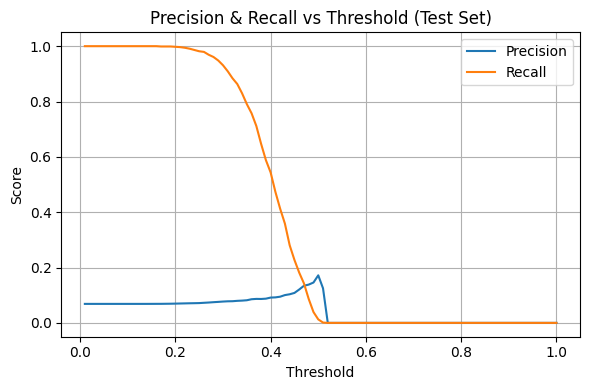

In [57]:
thresholds = np.round(np.linspace(0.01, 1.00, 100), 2)

precision_list = []
recall_list = []

for t in thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix on probability of max F1

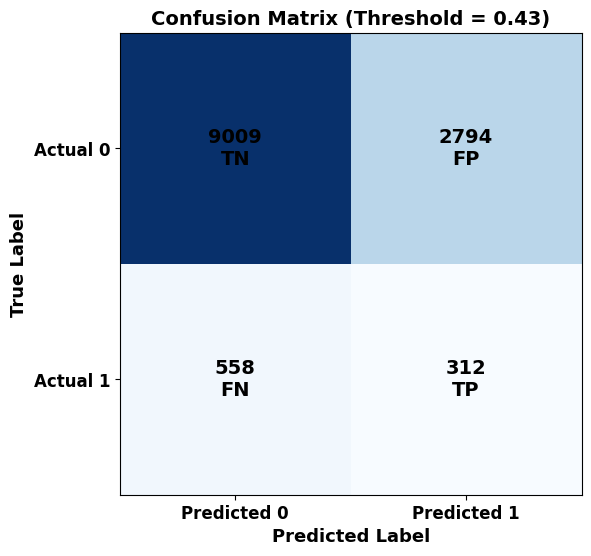

In [58]:
threshold = 0.43  
y_pred_binary = (y_test_pred >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

labels = np.array([
    ['TN', 'FP'],
    ['FN', 'TP']
])

fig, ax = plt.subplots(figsize=(6, 6))  
im = ax.imshow(cm, cmap='Blues')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted 0', 'Predicted 1'], fontsize=12, weight='bold')
ax.set_yticklabels(['Actual 0', 'Actual 1'], fontsize=12, weight='bold')
plt.xlabel('Predicted Label', fontsize=13, weight='bold')
plt.ylabel('True Label', fontsize=13, weight='bold')
plt.title(f'Confusion Matrix (Threshold = {threshold:.2f})', fontsize=14, weight='bold')

for i in range(2):
    for j in range(2):
        count = cm[i, j]
        label = labels[i, j]
        ax.text(j, i, f'{count}\n{label}', ha='center', va='center', 
                fontsize=14, weight='bold', color='black')

plt.tight_layout()
plt.show()

## Model Strategy and Experimentation

### Model Development

| Experiment Model         | # Features | AUC (Test) | AUC (OOS) | F1 (Test)    | Notes                                                                                                    |
|--------------------------|------------|------------|-----------|--------------|----------------------------------------------------------------------------------------------------------|
| baseline + FE            | 26         | 0.6087     | 0.6011    | 0.157 (43%)  | All existing variables + feature engineering                                                             |
| remove corr./low import. | 20         | 0.6157     | 0.6053    | 0.165 (43%)  | Removed: `avg_gb_used`, `used_gb_range`, `produkte&services-tarifwechsel_n`,                            |
|                          |            |            |           |              | `rechnungsanfragen_n`, `prolongation_n`, `has_multiple_contracts`                                       |
| remove low impact feat   | 16         | 0.6102     | 0.6025    | 0.161 (43%)  | Removed: `smartphone_brand`, `used_roaming_ratio`,                                                      |
|                          |            |            |           |              | `produkte&services-tarifdetails_n`, `has_special_offer`                                                 |



Our modelling strategy followed the following steps: 

1) Fit a model with all existing variables & the new ones we built trhough FE - All 26 variables are used (normally I would have split this step into 2, now due to time constraints did it in 1 step)

2) Fit a model after removing correlated and low importance variables from the previous step - Removed 6 variables which are either corre. or of 0 importance.

3) Fit a model after removing more low importance variables from the previous step - Removed 4 variables whose SHAP value importance was near 0.


Finally, the second model, i.e. the one with 20 variables appears to provide the best performance.

### Best Model Fit

In [23]:
X_train = pd.read_parquet("../data/processed/X_train.parquet", engine="pyarrow")
X_val = pd.read_parquet("../data/processed/X_val.parquet", engine="pyarrow")
X_test = pd.read_parquet("../data/processed/X_test.parquet", engine="pyarrow")
X_oos = pd.read_parquet("../data/processed/X_oos.parquet", engine="pyarrow")

In [24]:
convert_to_categorical(X_train, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_val, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_test, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])
convert_to_categorical(X_oos, ['has_special_offer', 'is_magenta1_customer', 'available_gb', 'smartphone_brand','has_multiple_contracts'])

In [25]:
X_val = X_val.sort_values(['customer_id_numeric']).reset_index(drop=True)
y_val = X_val['has_done_upselling']

# =========================================================================

##nfold = 3
##gkf = GroupKFold(n_splits=nfold)
##folds = list(gkf.split(X_val, y_val, groups=X_val['customer_id_numeric']))

##with open("folds_groupk_val.pkl", "wb") as f:
##    pickle.dump(folds, f)

with open("folds_groupk_val.pkl", "rb") as f:
    folds = pickle.load(f)

_, val0 = folds[0]
_, val1 = folds[1]
_, val2 = folds[2]

p0 = X_val.iloc[val0]['customer_id_numeric'].unique()
p1 = X_val.iloc[val1]['customer_id_numeric'].unique()
p2 = X_val.iloc[val2]['customer_id_numeric'].unique()

print("Overlap p0/p1:", any(x in p1 for x in p0))
print("Overlap p1/p2:", any(x in p2 for x in p1))
print("Overlap p0/p2:", any(x in p2 for x in p0))

# =========================================================================

lgbtrain = lgb.Dataset(
    X_val.drop([
        'customer_id', 'customer_id_numeric', 'rating_account_id', 'has_done_upselling', 'is_oos', 'usage_months',
        'avg_gb_used', 'used_gb_range', 
        'produkte&services-tarifwechsel_n','rechnungsanfragen_n','prolongation_n','has_multiple_contracts'	
    ], axis=1),
    label=y_val
)
# =========================================================================

N_HYPEROPT_PROBES = 20
HYPEROPT_ALGO = atpe.suggest
colorama.init()

log_writer = open(
    'lgb-hyperopt-log-test.txt', 'w'
)

kwargs = {
    'cur_best_loss': np.inf,
    'lgbtrain': lgbtrain,
    'folds': folds,
    'log_writer': log_writer
}

HYPEROPT_ALGO = tpe.suggest 

trials = Trials()

best = fmin(
    fn=(lambda a: objective(a, **kwargs)),
    space=space,
    algo=tpe.suggest,
    max_evals=N_HYPEROPT_PROBES,
    trials=trials, 
    verbose=1
)

Overlap p0/p1: False
Overlap p1/p2: False
Overlap p0/p2: False
Params: bagging_fraction=0.9830210265100577 cat_l2=8.84743817076961 cat_smooth=7.72292529252797 feature_fraction=0.8645003581671667 lambda_l1=2.094271489138645 lambda_l2=0.6009481665170396 max_depth=6.0 min_data_in_leaf=74.0 min_sum_hessian_in_leaf=0.07364135631836753 num_leaves=114.0
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

Training until validation scores don't improve for 50 rounds
[50]	valid's auc: 0.596859 + 0.0271154                
Early stopping, best iteration is:                    
[29]	valid's auc: 0.600671 + 0.0280951
First AUC values:                                     
[0.5693752327541182, 0.5781202686695125, 0.5775399265982454, 0.5780444338676083, 0.5822673535558728, 0.5852811020839307, 0.5852347717587054, 0.5854351587977843, 0.5880260695812373, 0.5919068352029883]
cvmodel keys:                                         
['valid auc-mean', 'valid auc-stdv']                  
nb_trees=29 test_loss=0.6006708362004746              
Params: bagging_fraction=0.7624978223623806 cat_l2=8.534362612229916 cat_smooth=0.8700207371300617 feature_fraction=0.7718639681182319 lambda_l1=3.209316896258148 lambda_l2=0.9139068582108981 max_depth=6.0 min_data_in_leaf=43.0 min_sum_hessian_in_leaf=0.08237175848092504 num_leaves=70.0
Training until validation scores don't improve for 50 rounds                     

In [26]:
lgb_param_best = get_lgb_params(best)

In [27]:
X_train = X_train
y_train = X_train['has_done_upselling']


lgbtrain = lgb.Dataset(
    X_train.drop([
        'customer_id', 'customer_id_numeric', 'rating_account_id', 'has_done_upselling', 'is_oos', 'usage_months',
        'avg_gb_used', 'used_gb_range', 
        'produkte&services-tarifwechsel_n','rechnungsanfragen_n','prolongation_n','has_multiple_contracts'
    ], axis=1),
    label=y_train
)

##nfold = 3
##gkf = GroupKFold(n_splits=nfold)
##folds = list(gkf.split(X_train, y_train, groups=X_train['customer_id_numeric']))

##with open("folds_groupk_train.pkl", "wb") as f:
##    pickle.dump(folds, f)

with open("folds_groupk_train.pkl", "rb") as f:
    folds = pickle.load(f)

print('cv started')
cvmodel = lgb.cv(
    lgb_param_best,
    lgbtrain,
    num_boost_round=10000,
    folds=folds,
    metrics='none',
    feval=metric_func,
    callbacks=[
        lgb.early_stopping(20),
        lgb.log_evaluation(period=0)
        ]
    )

best_num_boost_round = len(cvmodel['valid auc-mean'])     #### average AUC on the validation fold within each CV split
print('training started')
lgbmodel = lgb.train(
    lgb_param_best,
    lgbtrain,
    num_boost_round=best_num_boost_round
)
print('training ended')

cv started
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid's auc: 0.607575 + 0.0034099
training started
training ended


Store the model object

In [28]:
##with open('../models/final_model.pkl', 'wb') as f:
##    pickle.dump(lgbmodel, f)

with open('../models/final_model.pkl', 'rb') as f:
    lgbmodel = pickle.load(f)   

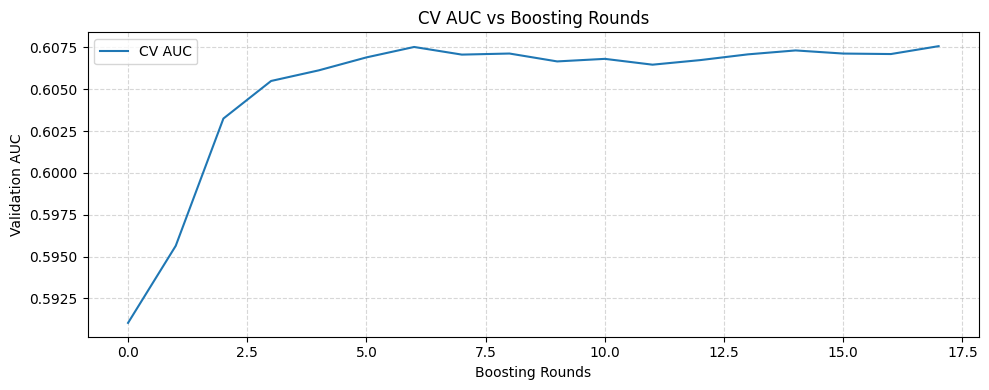

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(cvmodel['valid auc-mean'], label='CV AUC')
plt.xlabel("Boosting Rounds")
plt.ylabel("Validation AUC")
plt.title("CV AUC vs Boosting Rounds")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
y_test = X_test['has_done_upselling']
y_val = X_val['has_done_upselling']

model = lgbmodel

features_used = model.feature_name()

X_train_lgb = X_train[features_used]
X_val_lgb = X_val[features_used]
X_test_lgb = X_test[features_used]

y_train_pred = model.predict(X_train_lgb)
y_val_pred = model.predict(X_val_lgb)
y_test_pred = model.predict(X_test_lgb)

auc_train = roc_auc_score(y_train, y_train_pred)
auc_val = roc_auc_score(y_val, y_val_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Train AUC: {auc_train:.4f}")
print(f"Validation AUC: {auc_val:.4f}")
print(f"Test AUC: {auc_test:.4f}")

Train AUC: 0.6518
Validation AUC: 0.6233
Test AUC: 0.6157


In [31]:
X_oos = X_oos

y_oos = X_oos['has_done_upselling']

features_used = model.feature_name()

X_oos = X_oos[features_used]

y_oos_pred = model.predict(X_oos)

auc_oos = roc_auc_score(y_oos, y_oos_pred)

print(f"OOS AUC: {auc_oos:.4f}")

OOS AUC: 0.6053


In [32]:
display_thresholds = np.round(np.linspace(0.0, 1.0, 11), 2)
display_scores = []

for t in display_thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    display_scores.append((t, f1, precision, recall))

score_df_display = pd.DataFrame(display_scores, columns=['threshold', 'f1', 'precision', 'recall'])

fine_thresholds = np.round(np.linspace(0.01, 1.00, 100), 2)
fine_scores = []

for t in fine_thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    f1 = f1_score(y_test, y_pred_binary)
    fine_scores.append((t, f1))

fine_score_df = pd.DataFrame(fine_scores, columns=['threshold', 'f1'])
best_row = fine_score_df.loc[fine_score_df['f1'].idxmax()]

pd.set_option('display.float_format', '{:.3f}'.format)
print(" Precision, Recall, F1 at thresholds (10% steps):")
print(score_df_display.sort_values(by='threshold', ascending=False).to_string(index=False))

print(f"\n Max F1 score: {best_row.f1:.3f} at threshold = {best_row.threshold:.2f}")

 Precision, Recall, F1 at thresholds (10% steps):
 threshold    f1  precision  recall
     1.000 0.000      0.000   0.000
     0.900 0.000      0.000   0.000
     0.800 0.000      0.000   0.000
     0.700 0.000      0.000   0.000
     0.600 0.000      0.000   0.000
     0.500 0.080      0.124   0.059
     0.400 0.158      0.092   0.582
     0.300 0.143      0.077   0.940
     0.200 0.130      0.070   0.994
     0.100 0.128      0.069   1.000
     0.000 0.128      0.069   1.000

 Max F1 score: 0.165 at threshold = 0.43


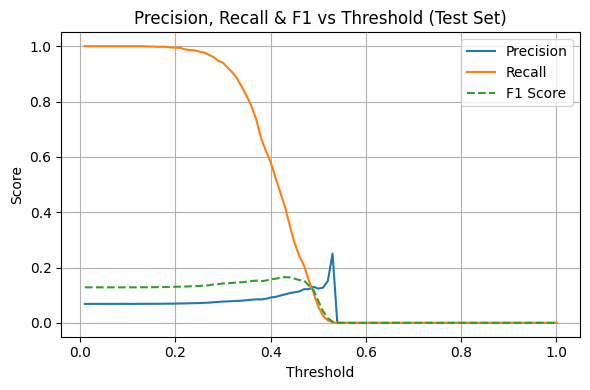

In [34]:
thresholds = np.round(np.linspace(0.01, 1.00, 100), 2)

precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    y_pred_binary = (y_test_pred >= t).astype(int)
    precision = precision_score(y_test, y_pred_binary, zero_division=0)
    recall = recall_score(y_test, y_pred_binary, zero_division=0)
    f1 = f1_score(y_test, y_pred_binary, zero_division=0)
    
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Plot the curves
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1 Score', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall & F1 vs Threshold (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

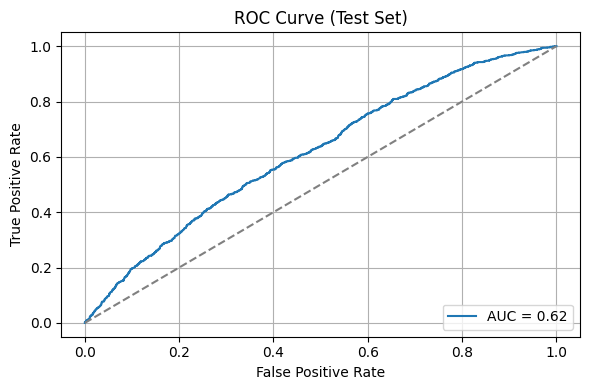

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


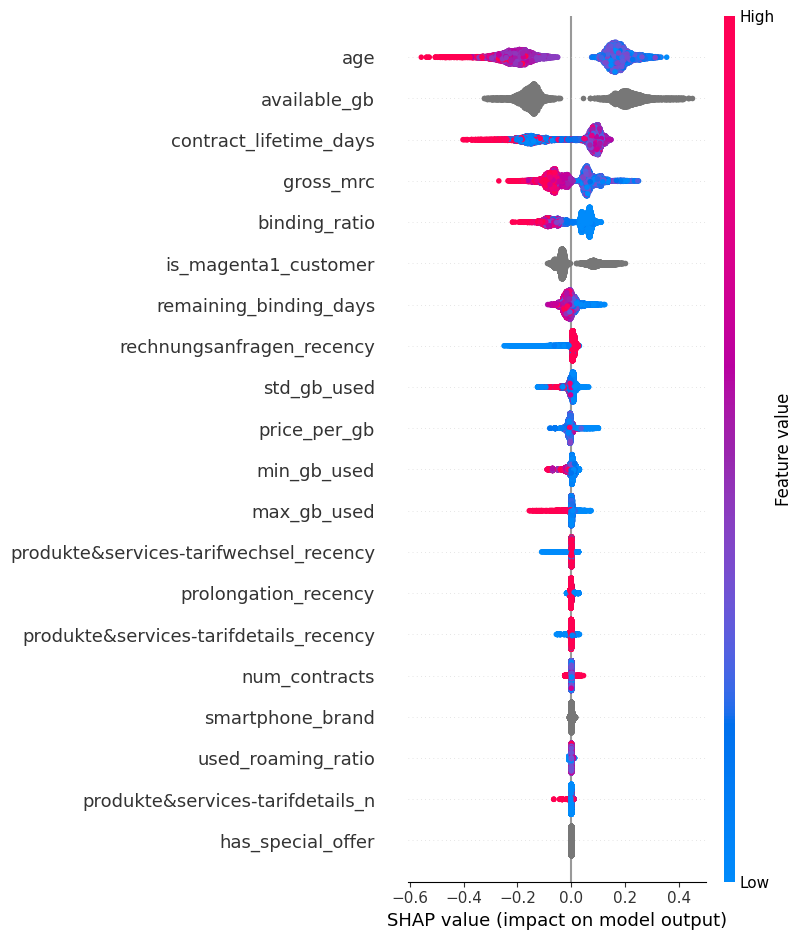

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_lgb)

    # If shap_values is a list (e.g., binary classifier), select class 1
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[1], X_test_lgb, show=True)
    else:
        shap.summary_plot(shap_values, X_test_lgb, show=True)

The SHAP values of the final model are very similar to the values of the baseline model, as expected. 

More specifically, age stands as top variable with lower values pushing the probability scores higher and higher values vice versa.

Similar are the effects of  available_gb, contract_lifetime_days, Gross_mrc and binding_ratio.

In [28]:
shap_vals = shap_values[1] if isinstance(shap_values, list) else shap_values

shap_importance = pd.DataFrame({
    'feature': X_test_lgb.columns,
    'mean_abs_shap': np.abs(shap_vals).mean(axis=0)
})

shap_importance = shap_importance.sort_values(by='mean_abs_shap', ascending=True)

shap_importance.sort_values('mean_abs_shap', ascending = False)

,feature,mean_abs_shap
0,age,0.192
5,available_gb,0.181
1,contract_lifetime_days,0.111
6,gross_mrc,0.070
18,binding_ratio,0.065
4,is_magenta1_customer,0.057
2,remaining_binding_days,0.018
12,rechnungsanfragen_recency,0.016
13,std_gb_used,0.011
19,price_per_gb,0.010


### Independent SHAP scores

In [ ]:
threshold = 0.43
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

eval_df = pd.DataFrame({
    'actual': y_test,
    'pred_proba': y_test_pred,
    'pred_label': y_test_pred_binary
})

eval_df['type'] = eval_df.apply(
    lambda row: 'TP' if row['actual'] == 1 and row['pred_label'] == 1 else
                'FP' if row['actual'] == 0 and row['pred_label'] == 1 else
                'TN' if row['actual'] == 0 and row['pred_label'] == 0 else
                'FN',
    axis=1
)


tp_index = eval_df[eval_df['type'] == 'TP'].index[0]
fp_index = eval_df[eval_df['type'] == 'FP'].index[0]

# Explain model
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_lgb)[1]

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


True Positive:


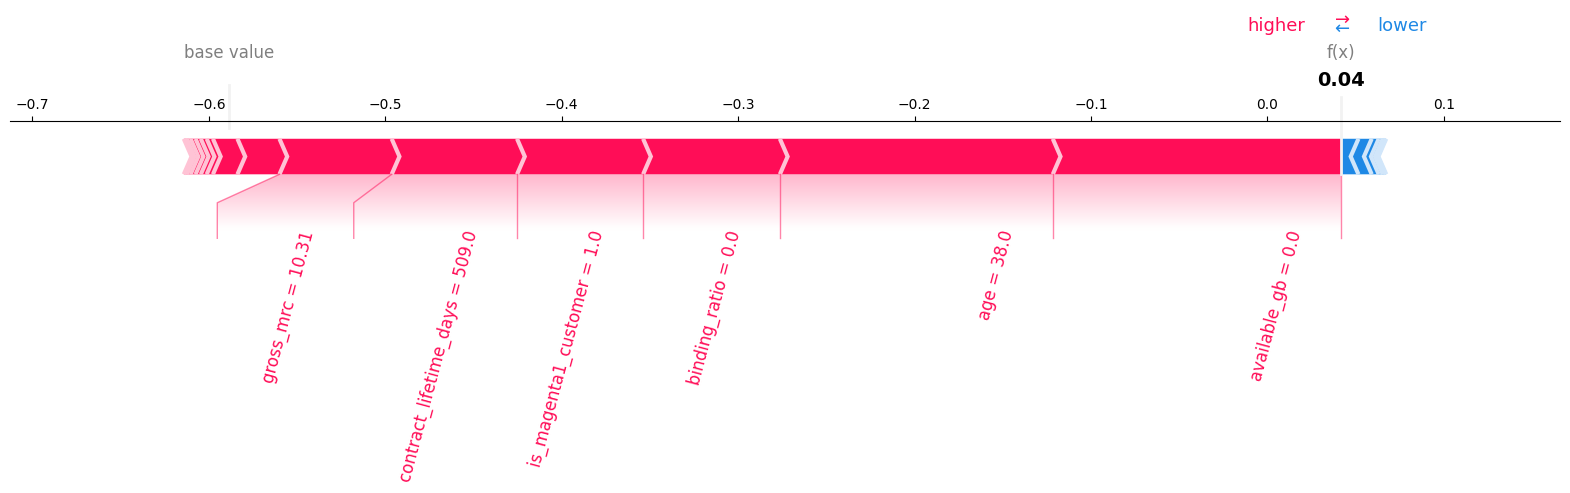

False Positive:


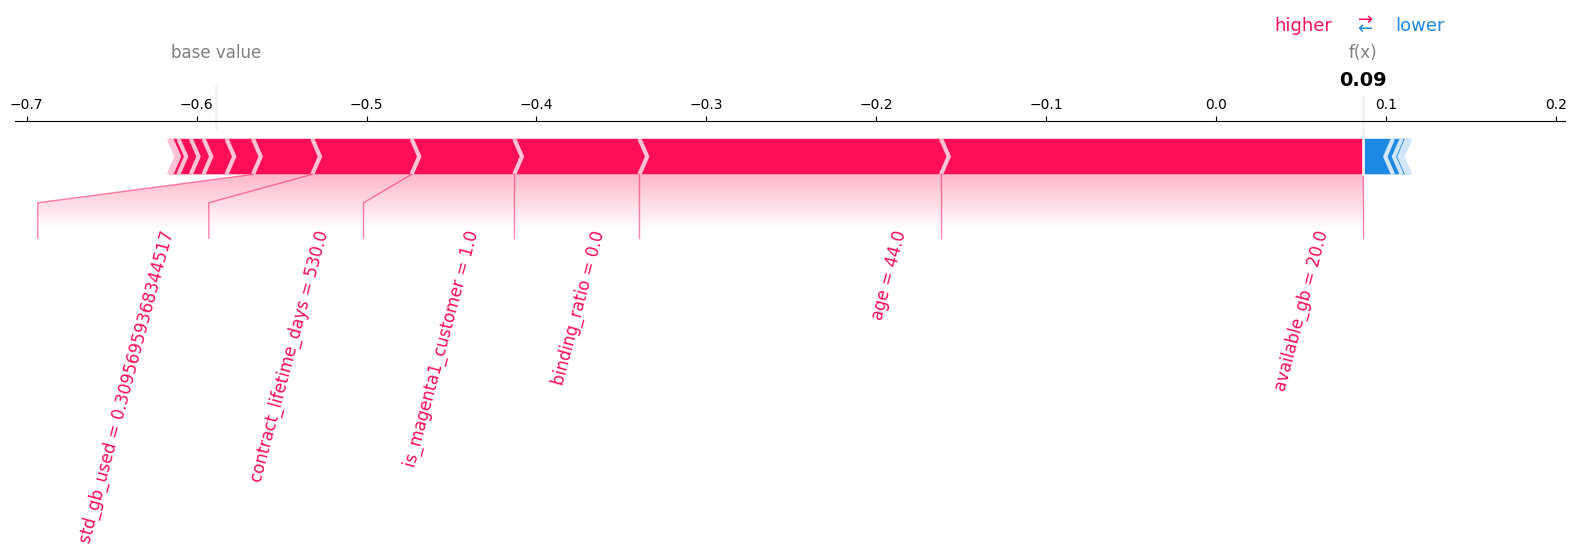

In [ ]:
# TP force plot
print("True Positive:")
shap.force_plot(
    explainer.expected_value[1],
    shap_values[tp_index],
    X_test_lgb.iloc[tp_index],
    matplotlib=True,
    text_rotation=75
)

# FP force plot
print("False Positive:")
shap.force_plot(
    explainer.expected_value[1],
    shap_values[fp_index],
    X_test_lgb.iloc[fp_index],
    matplotlib=True,
    text_rotation=75
)

The customer which was correctly predicted to be upsold, appears to get high scores mainly due to variables available_gb (which was 0, a low value), age (which was 38, again a low value) and binding ratio (which was zero).

On the other hand, the customer that was wrongly predicted as to be upsold, had a very similar profile to the TP. More specifically, he had low values again across available_gb, age and binding ratio.